**In this assignment, we aim to reconstruct the hidden vertex P4 of a cuboid using 
projective geometry and homogeneous coordinates.**

##### Perspective Geometry
A photograph is a perspective projection: 3D objects appear on a flat 2D image
from a single viewpoint. Because of this, parallel edges in 3D do not appear
parallel in the image.

##### Homogeneous Coordinates
Image points are written as (x, y, 1) so that lines and intersections can be 
computed using vector cross products. Homogeneous coordinates also allow us to 
represent points at infinity.

##### Vanishing Points
Parallel edges of the cuboid meet at a vanishing point in the image. The cuboid 
has three main directions (X, Y, Z), so it produces three vanishing points. 
These vanishing points allow us to reconstruct the hidden vertex P4.


*Loading image*

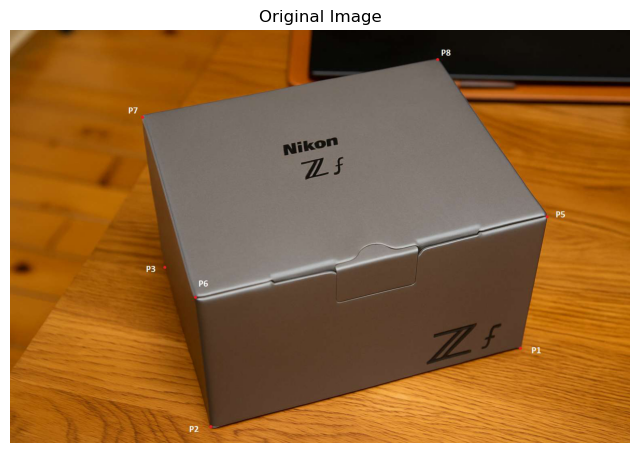

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "ppgr-1-picture_compressed.jpg"

img = mpimg.imread(image_path)

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
plt.show()

*Collecting Point Coordinates*   
The image was opened in Paint, the cursor was positioned over each marked vertex, 
and the pixel coordinates shown in the status bar were recorded. These coordinates 
are then written in homogeneous form (x, y, 1) in the following section.

In [2]:
p1 = (1266, 789, 1)
p2 = (497, 985, 1)
p3 = (384, 591, 1)
p5 = (1331, 464, 1)
p6 = (460, 665, 1)
p7 = (329, 218, 1)
p8 = (1060, 75, 1)

points = [p1, p2, p3, p5, p6, p7, p8]


*Helper Functions*   

- `line_through(p, q)`
  Returns the line passing through points p and q (computed as the cross product p × q).

- `intersection(l1, l2)`
  Computes the intersection point of two lines using the cross product l1 × l2,
  normalized to (x, y, 1).

- `average(points)`
  Returns the normalized mean point of several homogeneous points.

In [3]:
import numpy as np

def line_through(p, q):
    return np.cross(p, q)

def intersection(l1, l2):
    X = np.cross(l1, l2)
    return X / X[2]

def average(points):
    pts = np.array(points)
    m = np.mean(pts, axis=0)
    return m / m[2]


*Hidden-point Reconstruction Function*   
The function `eightpoint()` computes the hidden vertex P4 using the seven visible 
vertices of the cuboid. It works by:

1. Computing three vanishing-point estimates in each direction (X, Y, Z).
2. Averaging these estimates to obtain stable vanishing points.
3. Constructing three independent versions of P4 using line intersections.
4. Averaging the three P4 constructions to produce the final (x, y, 1) result.
   
The method is correct because it uses projective geometry rules: parallel edges
of the cuboid meet at the same vanishing point in the image. By computing three
vanishing points (Xb, Yb, Zb) and then reconstructing P4 from the lines that must
intersect at that vertex, we recover its true position in the photograph. Using
three independent constructions and averaging them reduces numerical error and
produces a stable and accurate P4.


In [4]:
def eightpoint(p1, p2, p3, p5, p6, p7, p8):
    Xb = average([
        intersection(line_through(p2, p6), line_through(p1, p5)),
        intersection(line_through(p2, p6), line_through(p7, p3)),
        intersection(line_through(p7, p3), line_through(p5, p1))
    ])

    Yb = average([
        intersection(line_through(p6, p5), line_through(p7, p8)),
        intersection(line_through(p2, p1), line_through(p6, p5)),
        intersection(line_through(p7, p8), line_through(p2, p1))
    ])

    Zb = average([
        intersection(line_through(p2, p3), line_through(p6, p7)),
        intersection(line_through(p5, p8), line_through(p6, p7)),
        intersection(line_through(p2, p3), line_through(p5, p8))
    ])

    P4 = average([
        intersection(line_through(Xb, p8), line_through(Yb, p3)),
        intersection(line_through(Xb, p8), line_through(Zb, p1)),
        intersection(line_through(Yb, p3), line_through(Zb, p1))
    ])

    return np.array([round(P4[0]), round(P4[1]), 1])


In [5]:
P4 = eightpoint(p1, p2, p3, p5, p6, p7, p8)

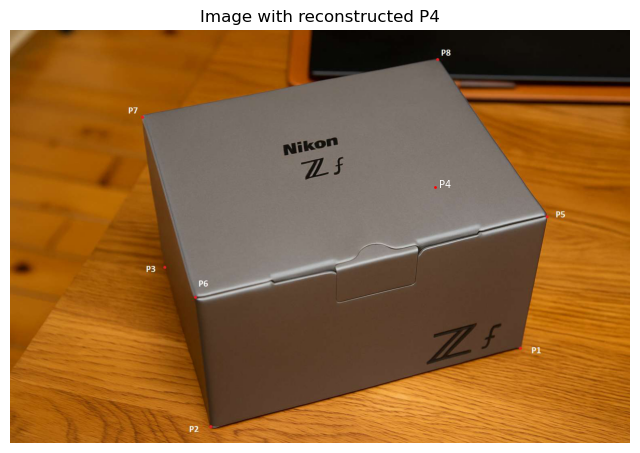


Reconstructed P4 — pixel coordinates: (1053, 390)


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("ppgr-1-picture_compressed.jpg")

plt.figure(figsize=(8,6))
plt.imshow(img)
plt.scatter(P4[0], P4[1], s=1, c='red')
plt.text(P4[0] + 10, P4[1], "P4", color='white', fontsize=7)
plt.axis('off')
plt.title("Image with reconstructed P4")
plt.savefig("ppgr-1-picture_with_P4.jpg", dpi=300, bbox_inches="tight")
plt.show()


print(f"\nReconstructed P4 — pixel coordinates: ({P4[0]}, {P4[1]})")